In [23]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import init
from H_10_models import SmallNetwork, MediumNetwork, LargeNetwork, ResLinearNetwork, LSTMNetwork
from model_configs import ModelDimConfigs, TrainingConfigs
from misc_tools import get_timestamp, ARPABET
from model_dataset import DS_Tools, Padder, TokenMap, NormalizerKeepShape
from model_dataset import SingleRecSelectBalanceDatasetPrecombine as ThisDataset
from model_filter import XpassFilter
from paths import *
from ssd_paths import *
from misc_progress_bar import draw_progress_bar
from misc_recorder import *
from H_11_drawer import draw_learning_curve_and_accuracy
import argparse
from H_21_stage import load_data

In [24]:
model_save_dir = os.path.join(model_save_, "H21-0324233831-1")

In [25]:
def load_data(type="f", sel="full", load="train"):
    if type == "l":
        mytrans = nn.Sequential(
            Padder(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, pad_len_ms=250, noise_level=1e-4), 
            XpassFilter(cut_off_upper=500),
            torchaudio.transforms.MelSpectrogram(TrainingConfigs.REC_SAMPLE_RATE, 
                                                n_mels=TrainingConfigs.N_MELS, 
                                                n_fft=TrainingConfigs.N_FFT, 
                                                power=2), 
            torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80), 
            NormalizerKeepShape(NormalizerKeepShape.norm_mvn)
        )
    elif type == "h": 
        mytrans = nn.Sequential(
            Padder(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, pad_len_ms=250, noise_level=1e-4), 
            XpassFilter(cut_off_upper=10000, cut_off_lower=4000),
            torchaudio.transforms.MelSpectrogram(TrainingConfigs.REC_SAMPLE_RATE, 
                                                n_mels=TrainingConfigs.N_MELS, 
                                                n_fft=TrainingConfigs.N_FFT, 
                                                power=2), 
            torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80), 
            NormalizerKeepShape(NormalizerKeepShape.norm_mvn)
        )
    elif type == "h2": 
        mytrans = nn.Sequential(
            Padder(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, pad_len_ms=250, noise_level=1e-4), 
            XpassFilter(cut_off_upper=10000, cut_off_lower=3500),
            torchaudio.transforms.MelSpectrogram(TrainingConfigs.REC_SAMPLE_RATE, 
                                                n_mels=TrainingConfigs.N_MELS, 
                                                n_fft=TrainingConfigs.N_FFT, 
                                                power=2), 
            torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80), 
            NormalizerKeepShape(NormalizerKeepShape.norm_mvn)
        )
    else: 
        mytrans = nn.Sequential(
            Padder(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, pad_len_ms=250, noise_level=1e-4), 
            torchaudio.transforms.MelSpectrogram(TrainingConfigs.REC_SAMPLE_RATE, 
                                                n_mels=TrainingConfigs.N_MELS, 
                                                n_fft=TrainingConfigs.N_FFT, 
                                                power=2), 
            torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80), 
            NormalizerKeepShape(NormalizerKeepShape.norm_mvn)
        )
    with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
        # Load the object from the file
        mylist = pickle.load(file)
        mylist.remove('AH') # we don't include this, it is too mixed. 

    if sel == "c": 
        select = ARPABET.intersect_lists(mylist, ARPABET.list_consonants())
    elif sel == "v":
        select = ARPABET.intersect_lists(mylist, ARPABET.list_vowels())
    else:
        select = mylist
    # Now you can use the loaded object
    mymap = TokenMap(mylist)
    if load == "train": 
        train_ds = ThisDataset(strain_cut_audio_, 
                            os.path.join(suse_, "guide_train.csv"), 
                            select=select, 
                            mapper=mymap, 
                            transform=mytrans)
        
        train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, f"train_{sel}.use"))
        use_train_ds = torch.utils.data.Subset(train_ds, train_ds_indices)
        train_loader = DataLoader(use_train_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                                shuffle=True, 
                                num_workers=TrainingConfigs.LOADER_WORKER)
        
        return train_loader
    elif load == "valid":
        valid_ds = ThisDataset(strain_cut_audio_, 
                            os.path.join(suse_, "guide_validation.csv"), 
                            select=select, 
                            mapper=mymap,
                            transform=mytrans)
        valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, f"valid_{sel}.use"))
        use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)
        valid_loader = DataLoader(use_valid_ds, batch_size=TrainingConfigs.BATCH_SIZE, 
                                shuffle=False, 
                                num_workers=TrainingConfigs.LOADER_WORKER)
        return valid_loader

In [26]:
low_valid_loader = load_data(type="l", sel="full", load="valid") # target 
high_valid_loader = load_data(type="h", sel="full", load="valid")
high2_valid_loader = load_data(type="h2", sel="full", load="valid")

In [27]:
low_data = np.empty((0, 21, 64))
low_label = np.empty((0,))
for idx, (x, y) in enumerate(low_valid_loader):
    x = x.squeeze(1).permute(0, 2, 1)
    x = x.numpy()
    y = y.numpy()
    low_data = np.concatenate((low_data, x), axis=0)
    low_label = np.concatenate((low_label, y), axis=0)

high_data = np.empty((0, 21, 64))
high_label = np.empty((0,))
for idx, (x, y) in enumerate(high_valid_loader):
    x = x.squeeze(1).permute(0, 2, 1)
    x = x.numpy()
    y = y.numpy()
    high_data = np.concatenate((high_data, x), axis=0)
    high_label = np.concatenate((high_label, y), axis=0)

high2_data = np.empty((0, 21, 64))
high2_label = np.empty((0,))
for idx, (x, y) in enumerate(high2_valid_loader):
    x = x.squeeze(1).permute(0, 2, 1)
    x = x.numpy()
    y = y.numpy()
    high2_data = np.concatenate((high2_data, x), axis=0)
    high2_label = np.concatenate((high2_label, y), axis=0)

# PCA test

In [28]:
import os
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

In [29]:
low_data_in = low_data.reshape(-1, low_data.shape[-1])
high_data_in = high_data.reshape(-1, high_data.shape[-1])
high2_data_in = high2_data.reshape(-1, high2_data.shape[-1])

In [30]:
def cluster_(data: np.ndarray, n_dim):
    pca = PCA(n_components=n_dim, random_state=42)
    pca.fit(data)
    # Calculate cumulative explained variance
    cev = np.cumsum(pca.explained_variance_ratio_)
    return cev

def analyze_variance_explained(cev):
    """
    Analyzes the cumulative explained variance and plots it.

    Args:
        cev (numpy.ndarray): Array of cumulative explained variance ratios.

    Returns:
        record (dict): min, max cev values and max component that cover 0.8,0.9,0.95,0.99 0f the variance
    """
    num_components = len(cev)

    # Plotting the cumulative explained variance
    plt.plot(range(1, num_components + 1), cev, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance vs. Number of Principal Components')
    plt.grid(True)
    plt.show()

    # Threshold analysis
    thresholds = [0.8, 0.9, 0.95, 0.99]  # Set desired threshold values
    thresholds_cev = []
    print(f"Min CEV: {np.min(cev)}\nMax CEV: {np.max(cev)}")
    for threshold in thresholds:
        num_components_threshold = np.argmax(cev >= threshold)
        num_components_threshold = num_components_threshold + 1 if num_components_threshold > 0 else None
        thresholds_cev.append(num_components_threshold)
        print(f"Number of components to explain {threshold * 100}% of variance: {num_components_threshold}")
    record = dict(zip(thresholds, thresholds_cev))
    record['min'] = np.min(cev)
    record['max'] = np.max(cev)
    return record

In [31]:
low_cev = cluster_(low_data_in, 64)
high_cev = cluster_(high_data_in, 64)
high2_cev = cluster_(high2_data_in, 64)

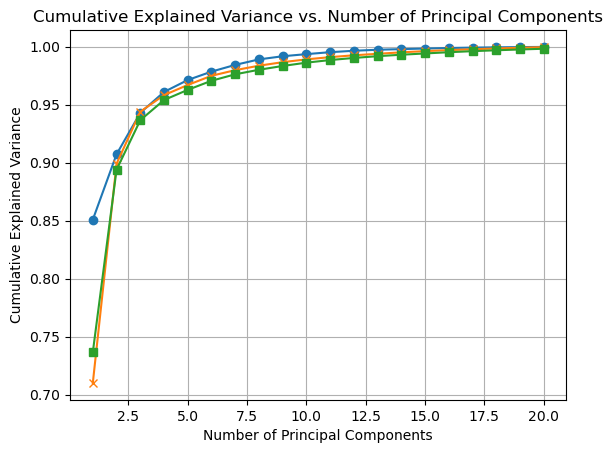

In [34]:
num_components = len(low_cev)
until = 20
# Plotting the cumulative explained variance
plt.plot(range(1, until + 1), low_cev[:until], marker='o')
plt.plot(range(1, until + 1), high_cev[:until], marker='x')
plt.plot(range(1, until + 1), high2_cev[:until], marker='s')
# plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Clustering

In [35]:
def cluster_cluster(data: np.ndarray, labels:list, n_clusters, n_init="auto", max_iter=100):
    '''
    This will perform pca+k-menas clustering, return predicted labels and evaluations.
    :param data: Preprocessed data
    :param labels: true labels
    :param n_dim: for pca
    :param n_clusters: for k-means
    :param n_init: "auto" or 10-30
    :param max_iter: 100-300
    :return: predicted_labels, evaluations
    '''
    st = time.time()
    # if data have >2 dimensions, reshape data. This is necessary for PCA.
    if data[0].ndim > 1:
        data = data.reshape(data.shape[0], -1)

    # convert label to integers
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(labels)
    n_clusters = len(label_encoder.classes_)

    # k-means clustering pipeline
    pipe = Pipeline(
        [
            (
                "kmeans",
                KMeans(
                    n_clusters=n_clusters,
                    # "random" is default, "k-means++" is advanced
                    init="k-means++",
                    # commonly 10-20
                    n_init=n_init,
                    # commonly ~300
                    max_iter=max_iter,
                    # always initialize centroid in the same way
                    random_state=37,
                ),
            ),
        ]
    )

    pipe.fit(data)
    # evaluate video data performance with silhouette coefficient
    predicted_data_labels = pipe["kmeans"].labels_
    data_silhouettesc = silhouette_score(data, predicted_data_labels)

    # evaluate video performance with ari
    data_adjustrandsc = adjusted_rand_score(true_labels, predicted_data_labels)
    # Use inverse_transform to convert the predicted labels back to the original labels
    predicted_original_labels = label_encoder.inverse_transform(predicted_data_labels)
    et = time.time()
    elapsed_time = et - st

    return predicted_original_labels, {
                                       "silhouette_score": data_silhouettesc,
                                       "adjusted_rand_score": data_adjustrandsc,
                                       "elapsed_time": elapsed_time}

In [36]:
low_pol, low_resdict = cluster_cluster(low_data, low_label, 37)
high_pol, high_resdict = cluster_cluster(high_data, high_label, 37)
high2_pol, high2_resdict = cluster_cluster(high2_data, high2_label, 37)

In [37]:
low_resdict, high_resdict, high2_resdict

({'silhouette_score': 0.12031570239753375,
  'adjusted_rand_score': 0.009117523428570801,
  'elapsed_time': 0.40820956230163574},
 {'silhouette_score': 0.07332958578144944,
  'adjusted_rand_score': 0.013937118160022374,
  'elapsed_time': 0.28058409690856934},
 {'silhouette_score': 0.06972149970684542,
  'adjusted_rand_score': 0.015759717044189846,
  'elapsed_time': 0.28670501708984375})

## MI

In [40]:
import numpy as np 
from sklearn.decomposition import PCA 
from sklearn.feature_selection import mutual_info_classif 
from sklearn.preprocessing import StandardScaler 

def mi_eval(X, y, pca_dim=None): 
    # Flatten spectrograms 
    num_samples, length, freq_bins = X.shape 
    X_flat = X.reshape(num_samples, length * freq_bins)

    # Standardize features 
    scaler = StandardScaler() 
    X_scaled = scaler.fit_transform(X_flat)

    # Dimensionality Reduction with PCA 
    if pca_dim: 
        pca = PCA(n_components=pca_dim, random_state=42)
        X_reduced = pca.fit_transform(X_scaled)
    else: 
        X_reduced = X_scaled

    # Mutual Information Estimation 
    mi = mutual_info_classif(X_reduced, y, discrete_features=False, random_state=42) 
    total_mi = np.sum(mi)

    # Optional: Normalize MI by number of features
    normalized_mi = total_mi / X_reduced.shape[1]

    return normalized_mi

In [39]:
mi_eval(low_data, low_label), mi_eval(high_data, high_label), mi_eval(high2_data, high2_label)

(0.10619495196372851, 0.1702494188030854, 0.17275761651002006)

In [44]:
# PCA 20
pca_dim = 10
mi_eval(low_data, low_label, pca_dim=pca_dim), mi_eval(high_data, high_label, pca_dim=pca_dim), mi_eval(high2_data, high2_label, pca_dim=pca_dim)

(0.05620600575135999, 0.053463135853673016, 0.0761268630216243)

# Conclusion
From CEV plot, I think the variation between the two datasets are not very different. We may not worry about this. 